In [1]:
import tensorflow as tf
#tensorflow_hub import 수행. 
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.10.0


In [3]:
!nvidia-smi

Sun Mar 10 19:42:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P5              18W / 170W |   1655MiB / 12288MiB |     18%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### TF Hub에서 EfficientDet d0 Inference 모델 다운로드 후 Inference 수행.
* 원하는 모델명은 TF Hub에서 검색해서 hub.lod()로 다운로드 후 tensorflow로 사용 가능할 수 있도록 로딩됨
* EfficientDet Tensorflow Object Detection API로 구현된 모델로 Download
* 로딩된 모델은 바로 원본 이미지로 Object Detection이 가능. 입력 값으로 numpy array, tensor 모두 가능하며 uint8로 구성 필요.

In [4]:
module_handle = "https://tfhub.dev/tensorflow/efficientdet/d0/1"
detector_model = hub.load(module_handle)

In [5]:
import cv2
import time
import numpy as np

img_array_np = cv2.imread('../data/beatles01.jpg')
img_array = img_array_np[np.newaxis, ...]
print(img_array_np.shape, img_array.shape)

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(img_array)
print('elapsed time:', time.time()-start_time)

(633, 806, 3) (1, 633, 806, 3)
elapsed time: 8.785100936889648


In [6]:
img_tensor = tf.convert_to_tensor(img_array_np, dtype=tf.uint8)[tf.newaxis, ...]
start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(img_tensor)
print('elapsed time:', time.time()-start_time)

elapsed time: 0.30504846572875977


In [7]:
# image를 numpy가 아니라 tensor로 로딩
def load_img(path):
  img = tf.io.read_file(path)
  #png 파일일 경우 decode_png()호출 
  img = tf.image.decode_jpeg(img, channels=3)
  print(img.shape, type(img))
  return img

In [8]:
import time 

# image를 tensor형태로 로딩. 
img = load_img('../data/beatles01.jpg')
# 3차원 image tensor를 4차원 tensor로 변환. 
# Efficientdet d0의 경우에는 입력 image를 unit8로 적용 필요. 
converted_img = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(converted_img)
print('elapsed time:', time.time()-start_time)


(633, 806, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
elapsed time: 0.16408276557922363


### inference 수행 반환값 확인 
* inference 결과는 dictionary 형태로 반환되며, 개별 key값은 Object Detection 모델에 따라 달라질 수 있음. 개별 value는 tensor로 되어 있음. 
* inference 반환된 bbox 좌표는 이미지 사이즈 대비 스케일링 된 0~1 사이 값이며 **ymin, xmin, ymax, xmax 형태로 반환되므로 반드시 주의 필요**

In [9]:
# inference 결과 출력. dictionary 형태의 출력 결과. dict내부의 key는 model 별로 서로 다름. 출력하여 key값 확인 필요. 
print(result)

{'detection_scores': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.94709915, 0.9358935 , 0.92999905, 0.89917976, 0.6260164 ,
        0.48423526, 0.34829932, 0.3154099 , 0.31249353, 0.30968836,
        0.28923836, 0.2678531 , 0.26184142, 0.2544499 , 0.24895594,
        0.24697506, 0.22533183, 0.22249252, 0.20146109, 0.19843423,
        0.1981241 , 0.19196011, 0.1892895 , 0.1878643 , 0.17240015,
        0.16985662, 0.16831174, 0.16796719, 0.16720028, 0.16623944,
        0.16579852, 0.16394845, 0.15602222, 0.14495029, 0.14486165,
        0.14443967, 0.14210206, 0.13971359, 0.1390531 , 0.13879964,
        0.13767868, 0.13685793, 0.13501394, 0.13208176, 0.13042791,
        0.12900354, 0.12587439, 0.1245574 , 0.12440289, 0.12235138,
        0.12187902, 0.1211169 , 0.12070345, 0.11955838, 0.11895207,
        0.11758913, 0.1163623 , 0.11571719, 0.11343459, 0.11332468,
        0.11086963, 0.1098238 , 0.10852645, 0.10815677, 0.10682373,
        0.10663762, 0.10599651, 0.10546231, 0

In [10]:
print(result.keys())
# detect 결과는 100개를 기본으로 Detect 함(즉 Detect된 오브젝트는 무조건 100개. 그래서 tensor(array)는 100개 단위, num_detections는 100) 
print(result['detection_boxes'].shape, result['detection_classes'].shape,  result['detection_scores'].shape, result['num_detections'])

dict_keys(['detection_scores', 'raw_detection_scores', 'detection_classes', 'detection_boxes', 'num_detections', 'detection_multiclass_scores', 'raw_detection_boxes', 'detection_anchor_indices'])
(1, 100, 4) (1, 100) (1, 100) tf.Tensor([100.], shape=(1,), dtype=float32)


In [11]:
# detect된 object들은 detection score가 높은 순으로 array값을 순차적으로 채움. 
print('#### detection_classes #####')
print(result['detection_classes'])
print('#### detection_scores #####')
print(result['detection_scores'])

#### detection_classes #####
tf.Tensor(
[[ 1.  1.  1.  1.  3.  3.  8. 41.  3.  3.  3.  3.  3. 41.  8.  3.  3.  3.
   3. 31. 31.  3.  3.  3.  3.  3.  3.  3. 31.  3.  3.  3.  3.  1.  3. 10.
   3.  3.  3. 31. 15. 32. 10.  3. 10.  1. 10.  3.  3.  3. 31.  1. 27. 10.
  33.  8.  3.  1. 31. 10.  3.  8.  3.  1.  3.  1.  3.  3.  3.  3.  3. 32.
   3.  1.  1. 31.  3. 31.  1.  3. 31. 10.  8.  3.  3. 32.  1.  1.  3. 10.
  41. 31.  1. 31. 10.  3.  3. 32. 31.  3.]], shape=(1, 100), dtype=float32)
#### detection_scores #####
tf.Tensor(
[[0.94709915 0.9358935  0.92999905 0.89917976 0.6260164  0.48423526
  0.34829932 0.3154099  0.31249353 0.30968836 0.28923836 0.2678531
  0.26184142 0.2544499  0.24895594 0.24697506 0.22533183 0.22249252
  0.20146109 0.19843423 0.1981241  0.19196011 0.1892895  0.1878643
  0.17240015 0.16985662 0.16831174 0.16796719 0.16720028 0.16623944
  0.16579852 0.16394845 0.15602222 0.14495029 0.14486165 0.14443967
  0.14210206 0.13971359 0.1390531  0.13879964 0.13767868 0.13685793
 

In [12]:
# bounding box 좌표는 ymin, xmin, ymax, xmax 순서로 반환됨. y가 먼저, x가 나중에 나오므로 반드시 주의해야 함. 
# 좌표 값은 원본 이미지의 width, height로 0~1 사이값으로 정규화됨. 
print('#### detection_boxes #####')
print(result['detection_boxes'])

#### detection_boxes #####
tf.Tensor(
[[[4.1179615e-01 6.3403547e-02 8.8110638e-01 2.6739836e-01]
  [4.3306497e-01 4.7706321e-01 8.9250082e-01 6.8626708e-01]
  [4.1960427e-01 6.8269742e-01 8.9689142e-01 8.9498472e-01]
  [4.1166285e-01 2.6408589e-01 8.6582935e-01 4.6427751e-01]
  [3.8654506e-01 1.7934524e-01 5.4317790e-01 3.2028949e-01]
  [3.6049891e-01 6.2639773e-01 4.6447214e-01 7.1949470e-01]
  [3.5996282e-01 6.2458962e-01 4.6351215e-01 7.1999604e-01]
  [7.1984404e-01 6.2759900e-01 8.6871320e-01 7.0305967e-01]
  [3.6647066e-01 3.8801238e-01 4.2244992e-01 4.3740979e-01]
  [3.5229814e-01 5.4655010e-01 3.8833058e-01 5.7694691e-01]
  [3.6912826e-01 5.8224022e-01 4.1025266e-01 6.2288988e-01]
  [3.7102902e-01 5.9425986e-01 4.3721148e-01 6.3780177e-01]
  [3.5444537e-01 4.7452095e-01 3.8302508e-01 4.9581340e-01]
  [7.1531206e-01 5.7744443e-01 8.7338579e-01 6.8965614e-01]
  [3.8983190e-01 1.7769226e-01 5.3870076e-01 3.1274652e-01]
  [3.5579628e-01 5.5833161e-01 3.9027113e-01 5.8628690e-01]
  

### inference 결과를 이미지로 시각화

In [13]:
# result내의 value들을 모두 numpy로 변환. 
result = {key:value.numpy() for key,value in result.items()}

In [14]:
# 1부터 91까지의 COCO Class id 매핑. 
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [15]:
def get_detector(module_handle="https://tfhub.dev/tensorflow/efficientdet/d0/1"):
  detector = hub.load(module_handle)
  return detector

detector_model = get_detector()

person: 0.9484
person: 0.9401
person: 0.9358
person: 0.8955
car: 0.6274
car: 0.5112
truck: 0.3303
car: 0.3148


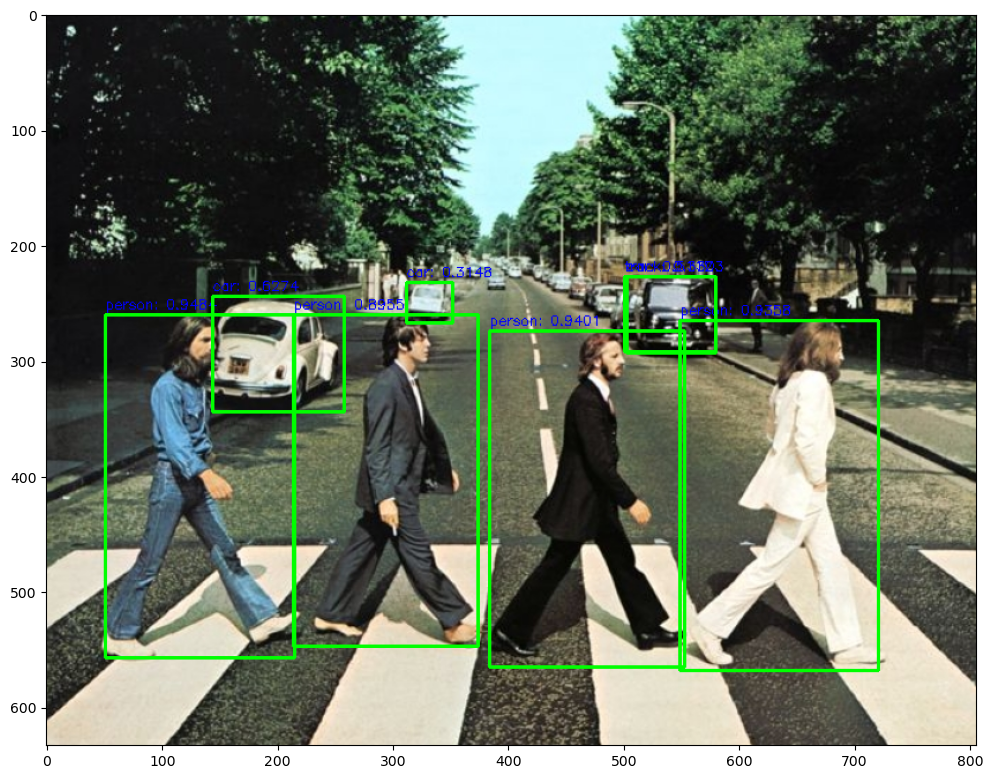

In [16]:
import cv2

img_array = cv2.cvtColor(cv2.imread('../data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

# scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
height = img_array.shape[0]
width = img_array.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img_array.copy()

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# cv2로 만들어진 numpy image array를 tensor로 변환
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
#img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

# pretrained 모델을 다운로드 한 뒤 inference 수행. 
result = detector_model(img_tensor)
# result 내부의 value를 numpy 로 변환. 
result = {key:value.numpy() for key,value in result.items()}

SCORE_THRESHOLD = 0.3
OBJECT_DEFAULT_COUNT = 100

# detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
for i in range(min(result['detection_scores'][0].shape[0], OBJECT_DEFAULT_COUNT)):
  # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
  score = result['detection_scores'][0, i]
  if score < SCORE_THRESHOLD:
    break
  # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
  box = result['detection_boxes'][0, i]

  ''' **** 주의 ******
   box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
  left = box[1] * width
  top = box[0] * height
  right = box[3] * width
  bottom = box[2] * height

  # class id 추출하고 class 명으로 매핑
  class_id = result['detection_classes'][0, i]
  caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
  print(caption)
  #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
  cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
  cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [17]:
import time

def get_detected_img(model, img_array, score_threshold, object_show_count=100, is_print=True):   
  # scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
  height = img_array.shape[0]
  width = img_array.shape[1]
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet모델로 inference 수행. 
  start_time = time.time()
  # inference 결과로 내부 원소가 Tensor이 Dict 반환 
  result = model(img_tensor)
  # result 내부의 value를 numpy 로 변환. 
  result = {key:value.numpy() for key,value in result.items()}

  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = result['detection_scores'][0, i]
    if score < score_threshold:
      break
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = result['detection_boxes'][0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
    left = box[1] * width
    top = box[0] * height
    right = box[3] * width
    bottom = box[2] * height

    # class id 추출하고 class 명으로 매핑
    class_id = result['detection_classes'][0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.9484
person: 0.9401
person: 0.9358
person: 0.8955
car: 0.6274
car: 0.5112
Detection 수행시간: 0.07 초


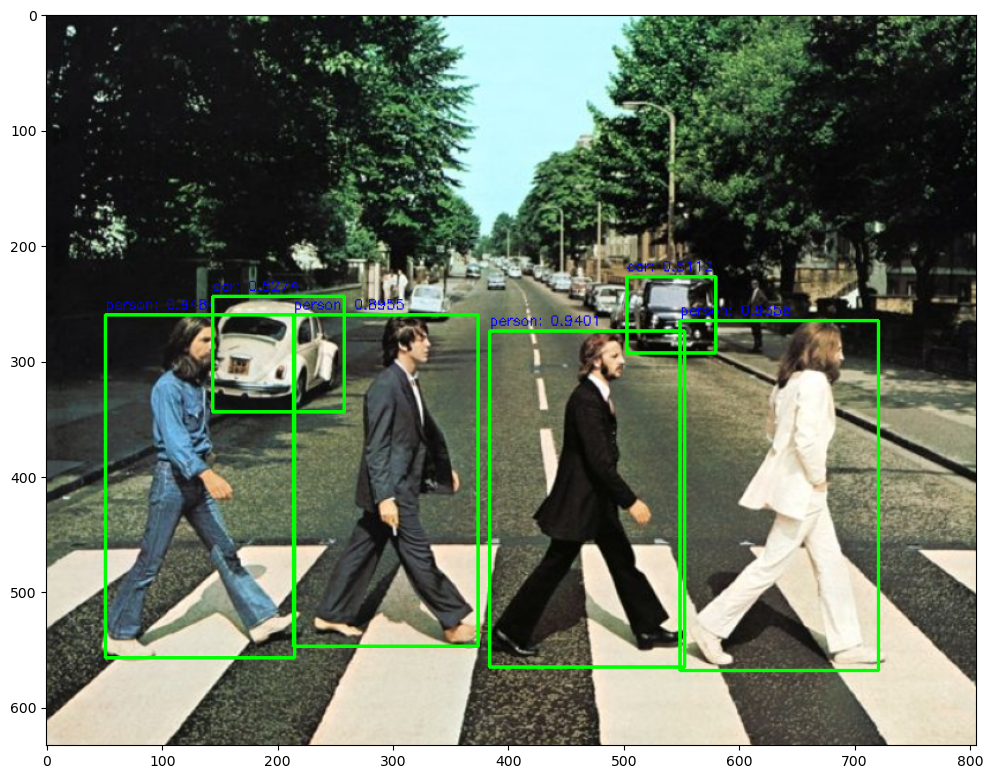

In [18]:
img_array = cv2.cvtColor(cv2.imread('../data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

person: 0.9570
person: 0.9252
person: 0.9069
baseball glove: 0.6338
baseball bat: 0.5930
Detection 수행시간: 0.22 초


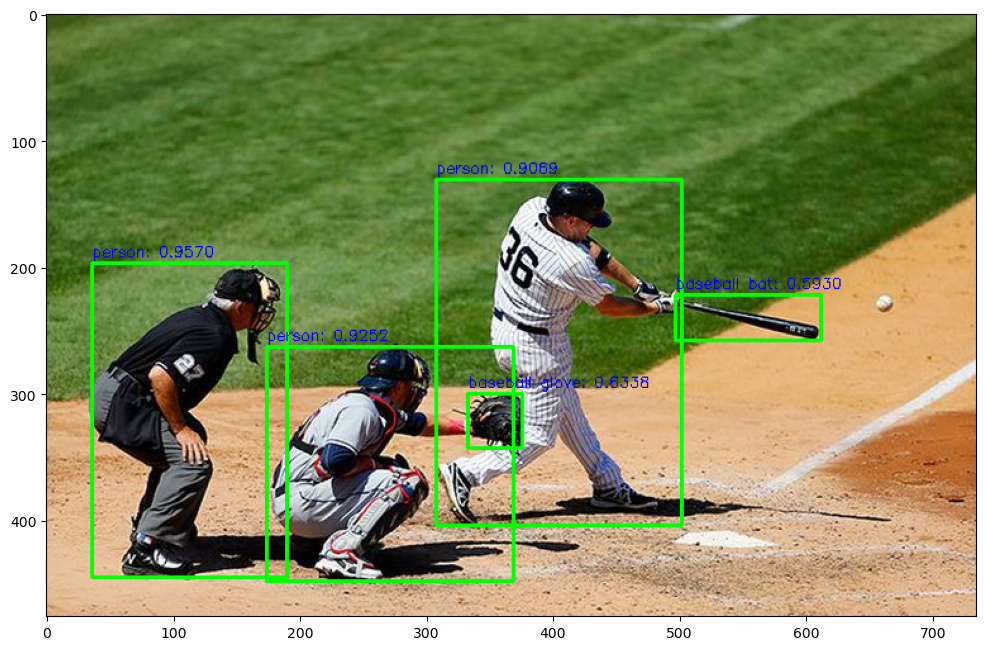

In [19]:
img_array = cv2.cvtColor(cv2.imread('../data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

### EfficientDet D2 모델로 Inference 수행. 

In [20]:
detector_model_d2 = get_detector('https://tfhub.dev/tensorflow/efficientdet/d2/1')

person: 0.9488
person: 0.9321
person: 0.8894
baseball glove: 0.8302
baseball bat: 0.6164
sports ball: 0.5034
Detection 수행시간: 2.77 초


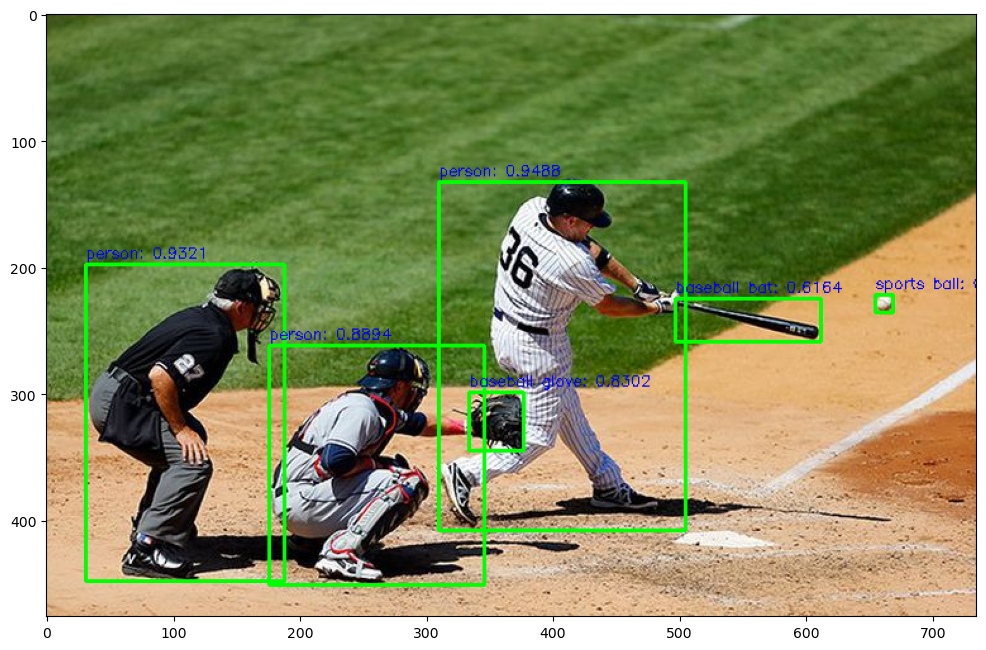

In [21]:
img_array = cv2.cvtColor(cv2.imread('../data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model_d2, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

### Video Inference 수행

In [22]:
def do_detected_video(model, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        img_frame = get_detected_img(model, img_frame, score_threshold=score_threshold, object_show_count=100, is_print=is_print)
        
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [23]:
do_detected_video(detector_model, '../data/John_Wick_small.mp4', '../data/John_Wick_small_02.mp4', 0.5, True)

총 Frame 갯수: 58
car: 0.7054
car: 0.6742
car: 0.6634
car: 0.6491
Detection 수행시간: 0.19 초
car: 0.7121
car: 0.6782
car: 0.6640
car: 0.6495
Detection 수행시간: 0.07 초
car: 0.6021
motorcycle: 0.5719
car: 0.5336
person: 0.5142
car: 0.5005
Detection 수행시간: 0.06 초
motorcycle: 0.5694
car: 0.5524
car: 0.5187
person: 0.5050
Detection 수행시간: 0.06 초
car: 0.6817
motorcycle: 0.5477
car: 0.5434
person: 0.5386
Detection 수행시간: 0.06 초
car: 0.6372
motorcycle: 0.5612
car: 0.5423
Detection 수행시간: 0.06 초
car: 0.6398
motorcycle: 0.5656
car: 0.5503
car: 0.5258
Detection 수행시간: 0.06 초
car: 0.7404
car: 0.7019
car: 0.6401
motorcycle: 0.5673
person: 0.5266
Detection 수행시간: 0.06 초
car: 0.6956
car: 0.6932
car: 0.6457
motorcycle: 0.5250
Detection 수행시간: 0.06 초
car: 0.7060
car: 0.6844
car: 0.6740
motorcycle: 0.5414
Detection 수행시간: 0.06 초
car: 0.7387
car: 0.6630
car: 0.6616
motorcycle: 0.5861
Detection 수행시간: 0.06 초
car: 0.7789
car: 0.7120
car: 0.6660
motorcycle: 0.5714
Detection 수행시간: 0.06 초
car: 0.7904
person: 0.6799
car: 0.6537


### EfficientDet lite0 Pretrained 모델 Inference 수행
* EfficientDet Lite는 automl 패키지로 구현됨. 
* 입력 이미지로 numpy array, tensor 모두 가능, type은 unit8 필요. 
* inference 결과로 box정보, score정보, class 정보를 각각 Tensor로 반환. 

In [24]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np

detector_automl_lite0 = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite0/detection/1")

In [25]:
img_array = cv2.cvtColor(cv2.imread('../data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
#img_array_01 = img_array[np.newaxis, ...]
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행. 
#boxes, scores, classes, num_detections = detector_automl_lite0(img_array_01)
boxes, scores, classes, num_detections = detector_automl_lite0(img_tensor)

print('elapsed time:', time.time()-start_time)

elapsed time: 0.9079575538635254


In [26]:
boxes.shape, scores.shape, classes.shape, num_detections

(TensorShape([1, 100, 4]),
 TensorShape([1, 100]),
 TensorShape([1, 100]),
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([100])>)

In [27]:
#좌표값이 0~1사이로 정규화 되지 않고 원본 이미지의 좌표값으로 반환 
print('원본 이미지 shape:', img_array.shape)
boxes[0, 0:10], scores[0, :10], classes[0, :10]

원본 이미지 shape: (476, 735, 3)


(<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
 array([[202.11862 ,  31.703558, 445.8127  , 188.72131 ],
        [259.2409  , 174.63206 , 455.4827  , 373.05975 ],
        [127.9438  , 324.8408  , 407.11694 , 493.3247  ],
        [300.98935 , 331.15485 , 344.10953 , 374.1984  ],
        [236.81339 , 542.4709  , 261.37903 , 609.6081  ],
        [222.15654 , 659.9847  , 236.20004 , 678.62744 ],
        [227.94942 , 496.09818 , 263.47784 , 610.31836 ],
        [223.7516  , 647.23596 , 238.01003 , 661.47784 ],
        [218.31815 , 654.4876  , 226.83354 , 662.96814 ],
        [220.96777 , 494.3059  , 246.90128 , 588.98364 ]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.9009264 , 0.88342166, 0.8454808 , 0.48576823, 0.38003293,
        0.27073678, 0.26300135, 0.25695384, 0.17530213, 0.17391555],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([ 1.,  1.,  1., 40., 39., 37., 39., 37., 37., 39.], dtype=float32)>)

In [28]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [29]:
def get_detected_img_automl(model, img_array, score_threshold, object_show_count=100, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, num_detections = model(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  num_detections = num_detections.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(num_detections[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    if score < score_threshold:
      break
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.9009
person: 0.8834
person: 0.8455
baseball glove: 0.4858
baseball bat: 0.3800
Detection 수행시간: 0.06 초


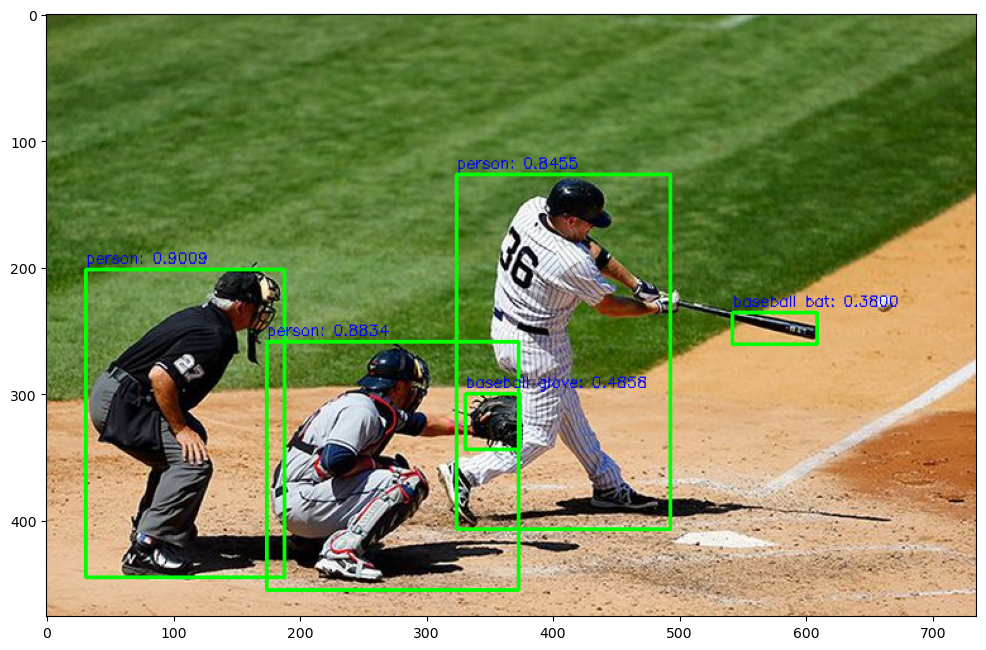

In [30]:
img_array = cv2.cvtColor(cv2.imread('../data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img_automl(detector_automl_lite0, img_array, score_threshold=0.3, object_show_count=100, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

person: 0.8216
person: 0.8134
person: 0.7396
person: 0.6830
car: 0.6209
car: 0.4220
car: 0.3185
Detection 수행시간: 0.95 초


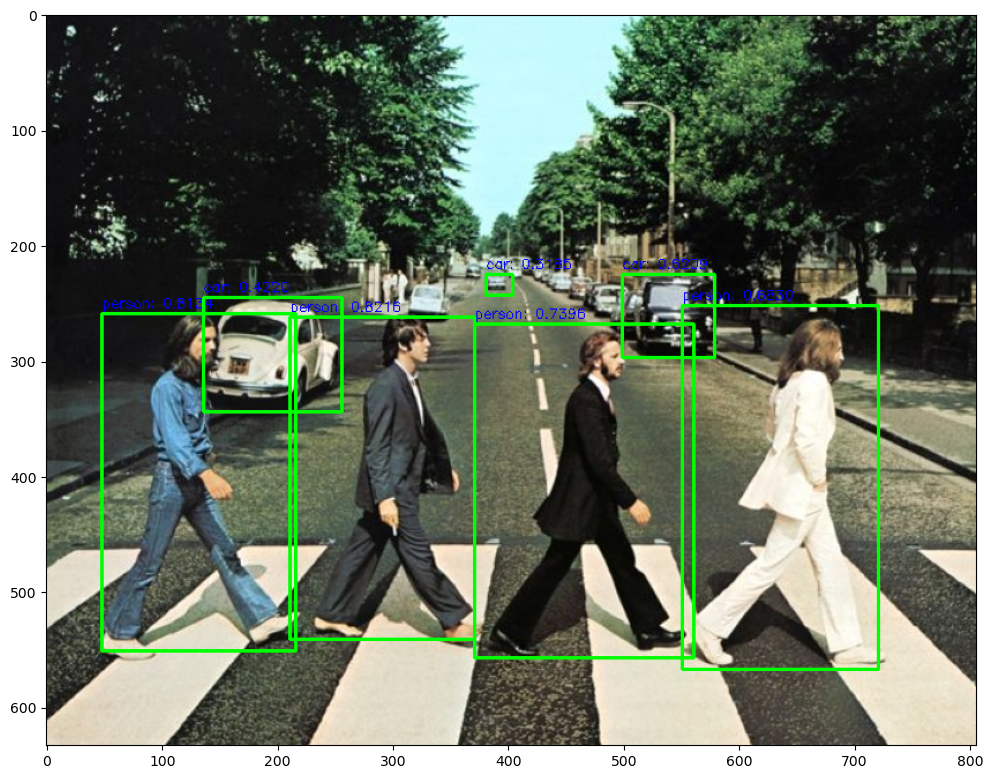

In [31]:
img_array = cv2.cvtColor(cv2.imread('../data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
draw_img = get_detected_img_automl(detector_automl_lite0, img_array, score_threshold=0.3, object_show_count=100, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

### EfficientDet lite2 모델로 inference 수행.

In [32]:
detector_automl_lite2 = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite2/detection/1")

person: 0.9151
person: 0.9088
person: 0.8914
person: 0.8807
car: 0.6070
car: 0.5115
Detection 수행시간: 1.18 초


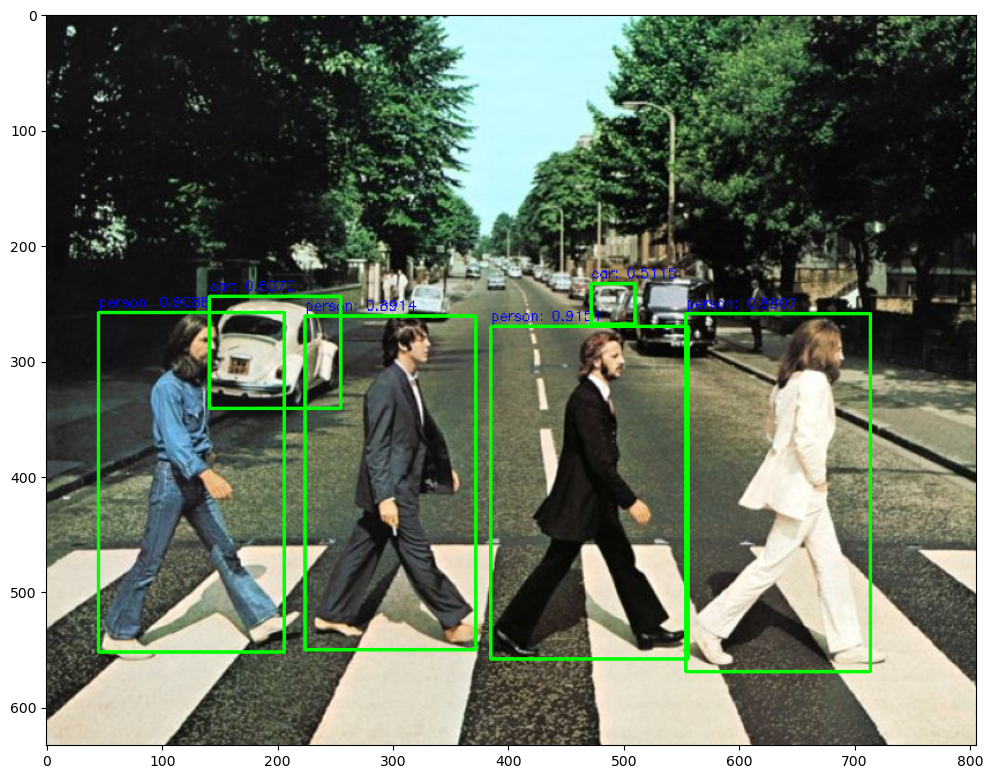

In [33]:
img_array = cv2.cvtColor(cv2.imread('../data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
draw_img = get_detected_img_automl(detector_automl_lite2, img_array, score_threshold=0.5, object_show_count=100, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [34]:
def do_detected_video_automl(model, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        # get_detected_img_automl() 호출 
        img_frame = get_detected_img_automl(model, img_frame, score_threshold=score_threshold, object_show_count=100, is_print=is_print)
        
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [35]:
do_detected_video_automl(detector_automl_lite2, '../data/John_Wick_small.mp4', '../data/John_Wick_small_lite_02.mp4', 0.5, True)

총 Frame 갯수: 58
car: 0.7213
car: 0.7048
person: 0.6838
car: 0.6668
car: 0.6558
car: 0.5765
Detection 수행시간: 1.12 초
car: 0.7209
car: 0.7069
person: 0.6855
car: 0.6601
car: 0.6559
car: 0.5791
Detection 수행시간: 0.07 초
car: 0.6067
person: 0.5957
car: 0.5876
car: 0.5706
Detection 수행시간: 0.02 초
car: 0.6772
person: 0.6324
car: 0.5552
Detection 수행시간: 0.02 초
car: 0.7092
person: 0.6329
car: 0.6052
car: 0.5058
Detection 수행시간: 0.02 초
car: 0.6944
car: 0.6897
person: 0.5411
Detection 수행시간: 0.02 초
car: 0.6894
car: 0.6828
person: 0.5329
Detection 수행시간: 0.02 초
car: 0.7332
car: 0.7108
car: 0.6808
motorcycle: 0.5111
Detection 수행시간: 0.02 초
car: 0.7302
car: 0.7147
motorcycle: 0.6325
car: 0.6055
Detection 수행시간: 0.02 초
car: 0.7211
car: 0.7189
motorcycle: 0.6323
car: 0.6045
Detection 수행시간: 0.02 초
car: 0.7077
car: 0.6671
car: 0.6343
motorcycle: 0.6324
Detection 수행시간: 0.02 초
car: 0.7144
car: 0.7092
car: 0.6082
motorcycle: 0.6037
Detection 수행시간: 0.02 초
car: 0.7379
car: 0.6947
motorcycle: 0.5521
car: 0.5494
Detection 